## Correlations by session

In [6]:
from groo.groo import get_root
root_dir = get_root(".root_dir_covid")

import os

print(root_dir)
import sys
sys.path.append(os.path.join(root_dir, "covid-fear", "scripts"))


import numpy as np
import pandas as pd
from cov_functions import *
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
import itertools
warnings.filterwarnings('ignore')
from scipy.spatial.distance import correlation as Dcorr
import bambi as bmb
import arviz as az
import json
import pickle 
import bammm.bammm as mm
from scipy.stats import zscore as zscore_sc


# load main dataset
df = pd.read_csv(os.path.join(root_dir, "data", "full_dataset_only_complete_based_on_sess_avg.csv"))
#sys.path.insert(1, os.path.join(root_dir, "covid-fear", "scripts", "lib", "hoeffding"))


##### VERY IMPORTANT ####

df["cases"] = df["cases14_std_unsmooth"]
df["deaths"] = df["deaths14_std_unsmooth"]

tdf = df.loc[df["sess_str"]=="sess0",:]
tdf = tdf.loc[:,["PROLIFICID", "q7_worry_infected", "q8_prob_inf_me" ]]
tdf = tdf.rename(columns={"q7_worry_infected": "worry_infected_sess1", 
                          "q8_prob_inf_me": "prob_infected_sess1"  }).set_index("PROLIFICID")
tdf = tdf.loc[df.loc[df["sess_str"]=="sess19","PROLIFICID"],:]


#df = df.set_index("PROLIFICID")
#df = df.join(tdf, how="left")
#df2.prob_infectes_sess1
##df["memory_worry_infected_baselined"] = df["q7_worry_infected"] - df["worry_infected_sess1"]
#df["memory_prob_infected_baselined"] = df["q8_prob_inf_me"] - df["prob_infected_sess1"]

##### VERY IMPORTANT ####

mapdict = {'TF3_NegativeAffect': 'TF3',
           'TF2_PhysiolAnx': 'TF2', 
           'TF1_CognAnxDepr': 'TF1',
           'stai_ta': "TA",
           'covid_worry': 'Worry', 
           'prob_est': 'ProbabilityEstims',
           'q7_worry_econ_impact': 'EconWorry',
           'q6_apply_soc_dist': 'SocialDist',
           'q6_risk_group': 'RiskGroup',
           'avoid_beh': 'AvoidBeh',
           'avoid_anx': 'AvoidAnx',
           'q6_media_freq_num': 'InforSeek',
           'q6_media_valence': 'MediaValence',
           'q7_period_rel_danger': 'CurrentThreat',
           'deaths': 'Deaths',
           'cases': 'Cases',
           'worryhealth': 'HealthWorry',
           'q6_work_home': "WorkHome",
           'q6_houshold_membs': "HouseholdMembers",
           'sticsa_som_sa_currsess': "StateSomAnx",
       #    "q6_close_person_infdied": "ClosePDied",
            "covid_thoughts": "CovThoughts", 
            "memory_worry_infected_baselined": "MemWorry", 
            "memory_prob_infected_baselined": "MemProb", 

            #"affheallth-econ-worry": "Health>Econ \n worry", 
            #"covid_cases_est_diff": "Estimate of \n covid cases"
           }

df=df.rename(columns=mapdict)

# Create column with appropriate dates
df["Session"] = df["session"] + 1
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="Session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["session"] = months["Session"]-1

## transform and generate some variables (to be moved to preprocessing)

vars = [
        # core things interested in 
        "Deaths",
        "Cases",
        "CurrentThreat",
        "ProbabilityEstims",
        "InforSeek",
        "AvoidBeh",
        "Worry"
        ]

# Zscore
#for c in vars: 
#    df[c] = df.groupby(by="Session")[c].apply(zscore_sc, nan_policy="omit")






/data/drive/postdoc/Project4_covid


## calculate diferences 

In [7]:
for var in vars:
    df[f'{var}_diff'] = df.groupby('PROLIFICID')[var].diff()

# Now, df contains the difference columns for each variable; the first difference for each participant will be NaN
# You can drop these NaNs if you only want the valid differences
df = df.dropna(subset=[f'{var}_diff' for var in vars])


In [8]:
### Meta parameters
corr_type = "spearman" # used in all analyses

no_covid_factors = 3
if no_covid_factors ==6:
    factors =[ "F1_Close_Person_Worry","F2_Anxiety_Avoidance", "F3_Economic_Impact_Worry", "F4_Prob_Estimates", "F5_Worry", "F6_Skepticism"]
elif no_covid_factors==3:
    factors = ["F1_CovidAnxietyWorry", "F2_CovidProbabilityEsts", "F3_Economic"]
    
#print("State seveirty NaNs: "+str(df["state_severity"].isna().sum())+" out of entries: "+ str(df.shape[0]))

no_trait_factors = 3
if no_trait_factors == 6:
        trait_factor_names = ["TF1_Self_Consciousness", "TF2_Positive", "TF3_Catastrophizing",  "TF4_Physiological_Anx",  "TF5_Depression",  "TF6_Cognitive_Anx"]
elif no_trait_factors==5:
    trait_factor_names = ["TF1_Worry", "TF2_Self_Worth", "TF3_Catastrophizing",  "TF4_Anxiety",  "TF5_Depression"]    
elif no_trait_factors==3:
        trait_factor_names = ["TF1_CognAnxDepr",  "TF2_PhysiolAnx","TF3_NegativeAffect" ]
        tfs = ["TF"+str(x) for x in range(1,4)]
elif no_trait_factors==2:
        trait_factor_names = ["TF2_PhysiolAnx", "TF1_CognAnxDepr"]
elif no_trait_factors==44:
        trait_factor_names = ["TF3_NegativeAffect", "TF2_PhysiolAnx", "TF1_CognAnxDepr","stai_ta"]
elif no_trait_factors==99:
    trait_factor_names = ["stai_ta", "sticsa_ta", "cat", "bdi"] 




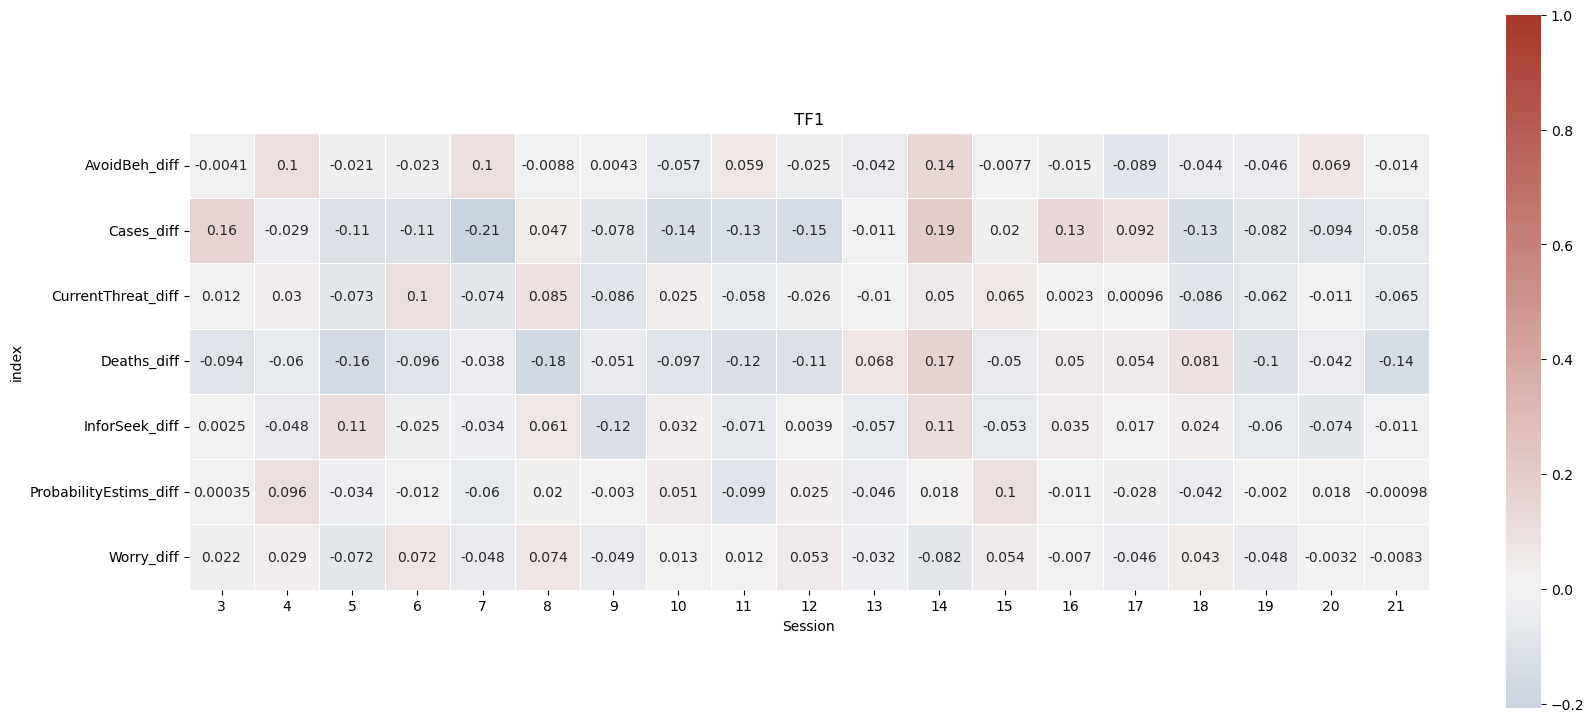

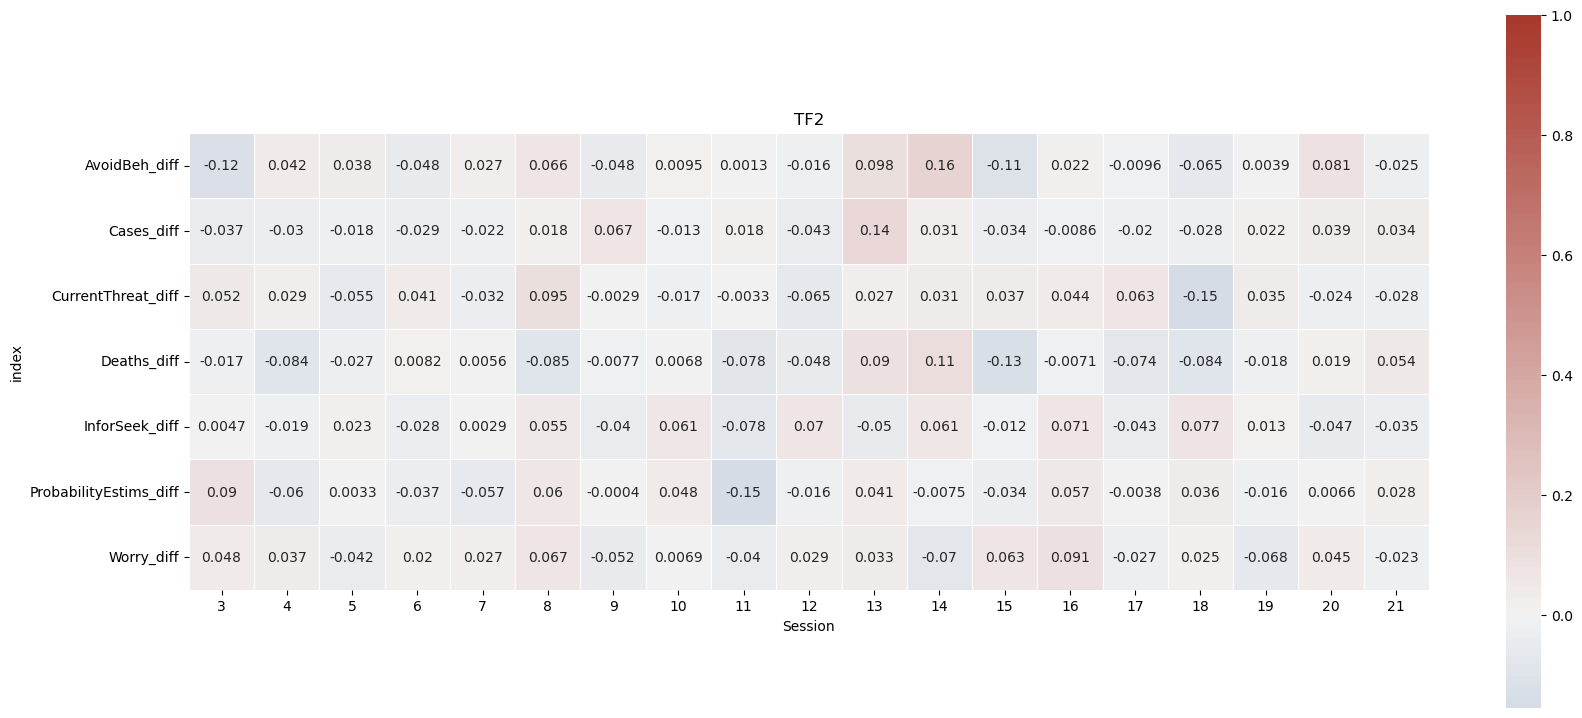

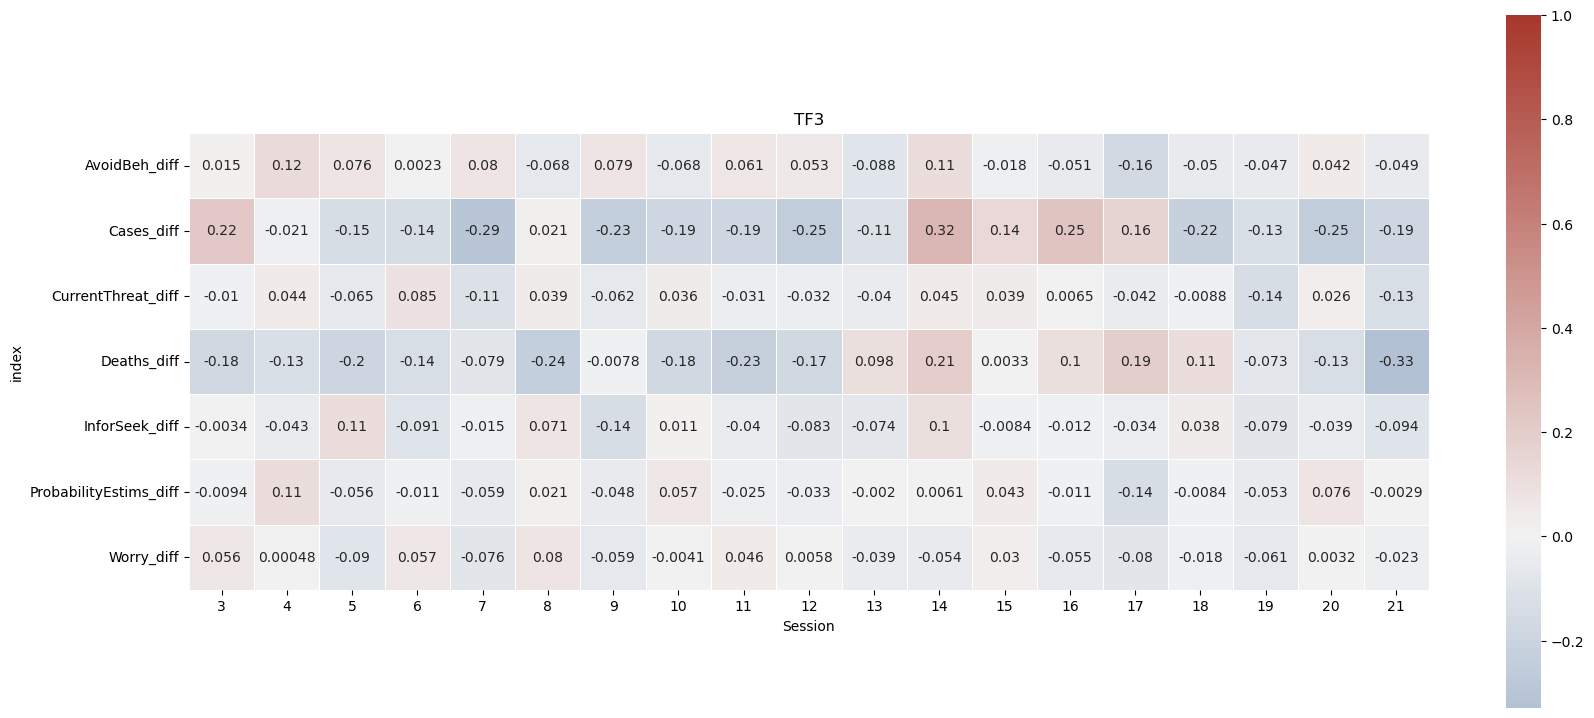

In [10]:
vars2 = [v+"_diff" for v in vars]
cordf = pd.DataFrame()
for s in df["Session"].unique():
    

    data = df.loc[df["Session"]==s,vars2+tfs] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    #for f in factors:
    #    data["r_"+f] = np.nan
    #    # append to vars
    #    vars = vars+["r_"+f]
    #    for s in df["PROLIFICID"].unique():
    #        data["r_"+f][s] = df.loc[df["PROLIFICID"].isin([s])][["state_severity",   f]].corr(corr_type).loc["state_severity"][f]

    #print("State seveirty NaNs: "+str(data["state_severity"].isna().sum())+" out of entries: "+ str(data.shape[0]))

    # calculate correlation matrix
    corr = data.corr(corr_type)
    #print(corr)
    corr2 = corr.loc[tfs, ~corr.index.isin(tfs)].T.reset_index()
    corr2["Session"] = s
    cordf = pd.concat([cordf, corr2])
    # Generate a mask for the upper triangle
    #mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    #f, ax = plt.subplots(figsize=(35, 24))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(250, 15, s=75, l=40,
    #                            n=9, center="light", 
    #                            as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    #sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
    #            square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5})

    #data.to_csv(os.path.join(root_dir, "data", "summarized_data_for_secondary_factor_analysis.csv"))
for t in tfs:

    td = cordf.loc[:,["index", "Session", t]]
    td = td.pivot(index="index", columns="Session", values=t )
    #mask = np.triu(np.ones_like(td, dtype=bool))
    f, ax = plt.subplots(figsize=(20, 18))
    cmap = sns.diverging_palette(250, 15, s=75, l=40,
                                    n=9, center="light", 
                                    as_cmap=True)
    ax = sns.heatmap(td, cmap=cmap, vmax=1, center=0,
                    square=True, annot=True,linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
    ax.set_title(t)


In [11]:
data = df.groupby(by=[x+"_ms" for x in trait_factor_names] + ["PROLIFICID", "Session"])[["PROLIFICID"]+vars2].mean().reset_index()
tdata = data.melt(id_vars=vars2+["Session"], value_vars=[x+"_ms" for x in trait_factor_names], var_name="traitf", value_name="level" )

#trait_factor_names =trait_factor_names+ [x+"_ms" for x in trait_factor_names]
    

In [12]:
colist= [[  "navy", "dodgerblue"], ["crimson", "lightcoral"], ["xkcd:dark sea green", "xkcd:pale teal"]]
# checked for color blindness

[colist[x][0] for x in range(3)]

['navy', 'crimson', 'xkcd:dark sea green']

Deaths_diff
Cases_diff
CurrentThreat_diff
ProbabilityEstims_diff
InforSeek_diff
AvoidBeh_diff
Worry_diff


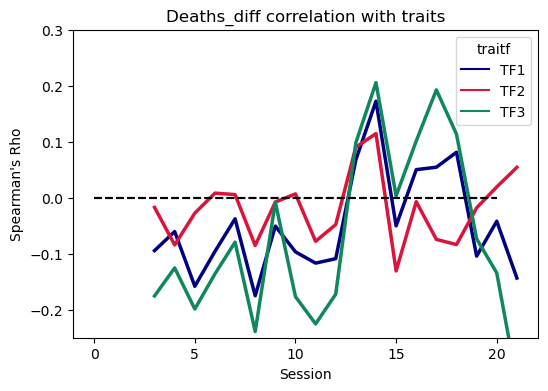

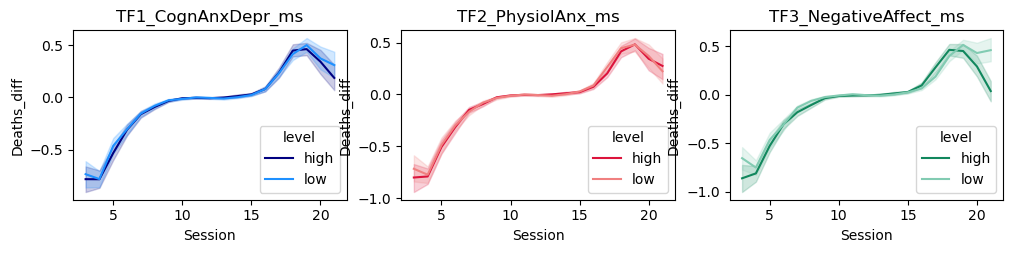

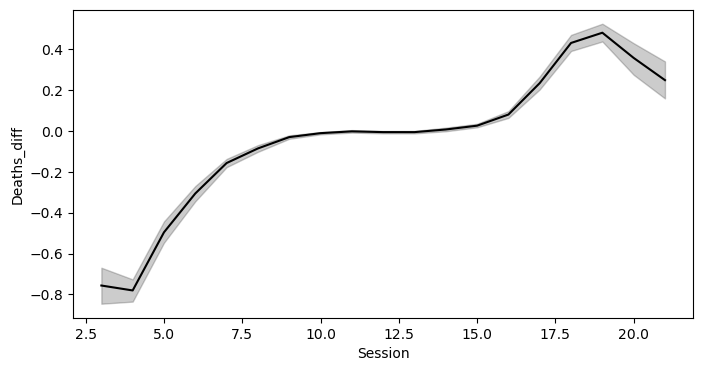

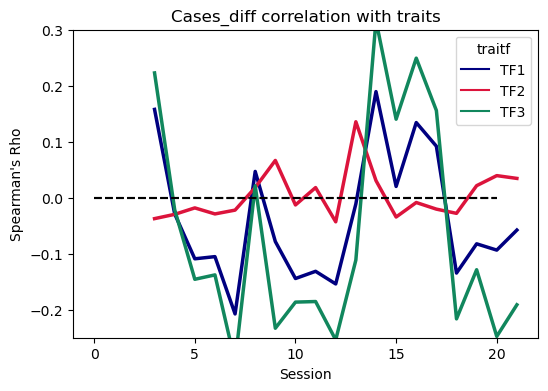

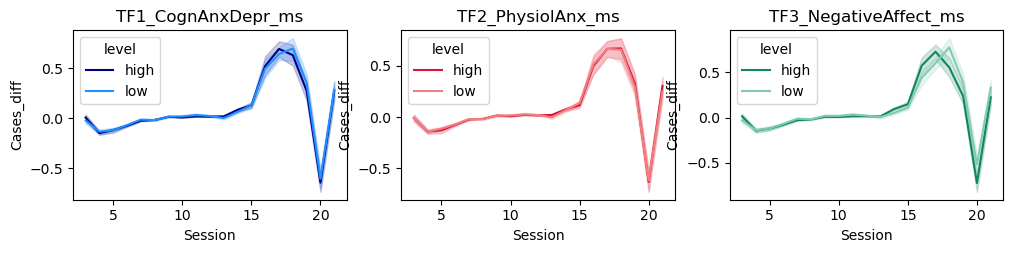

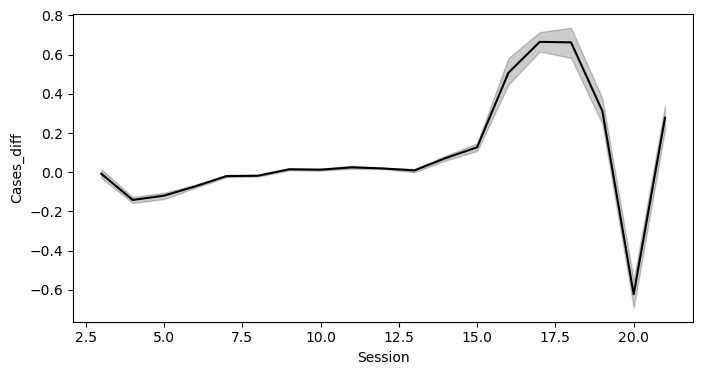

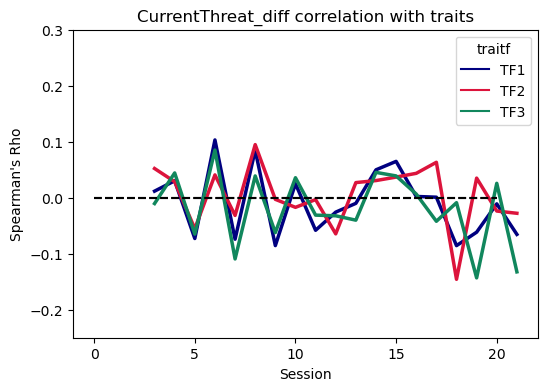

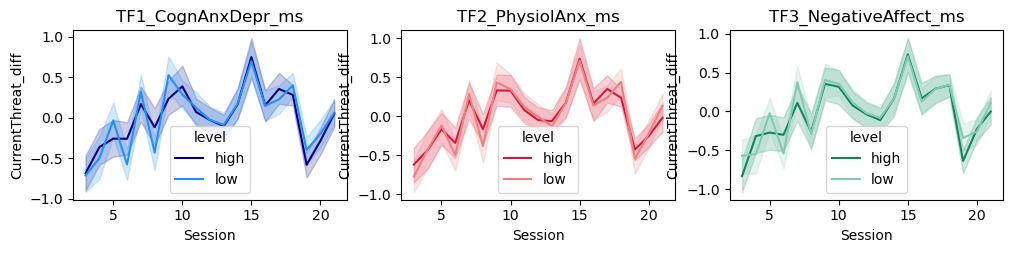

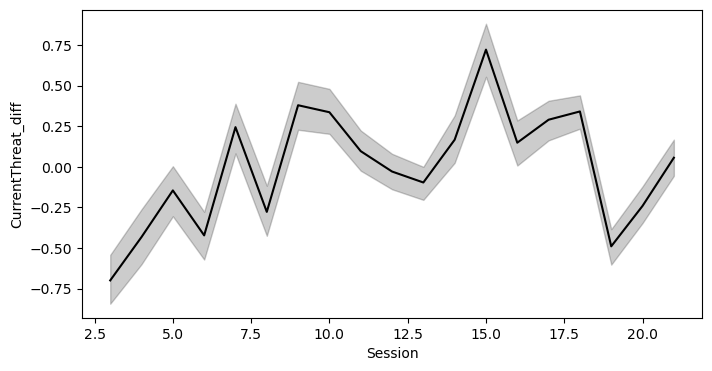

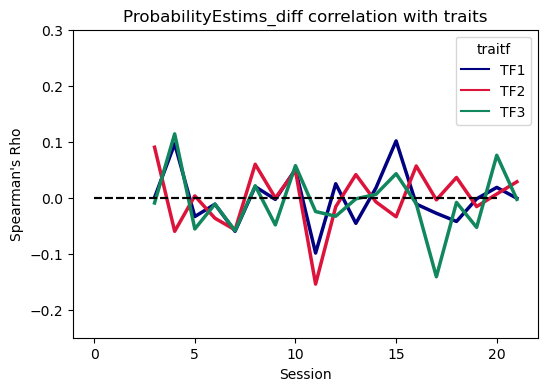

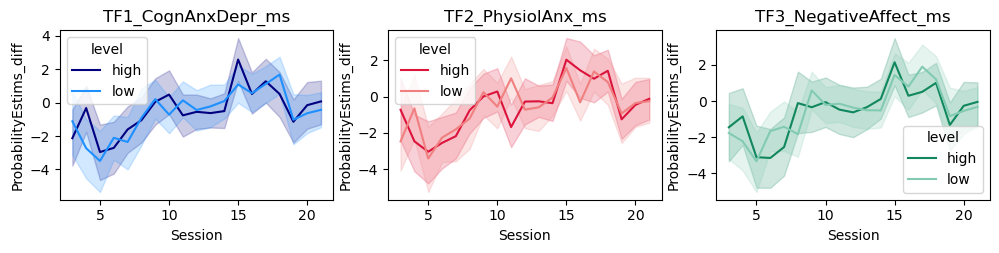

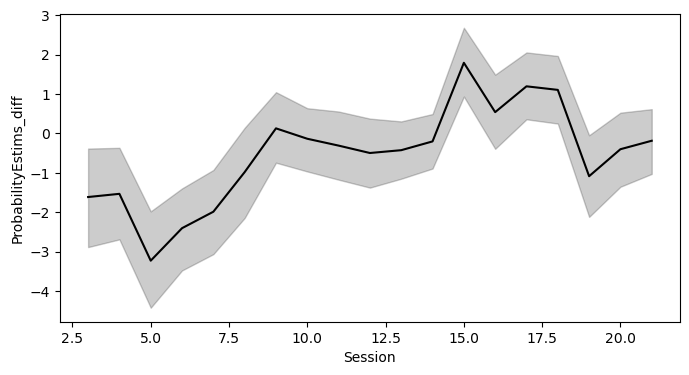

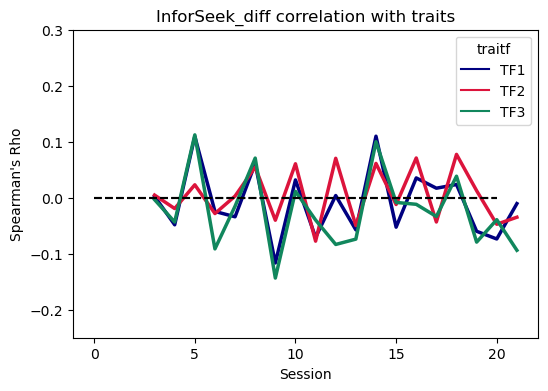

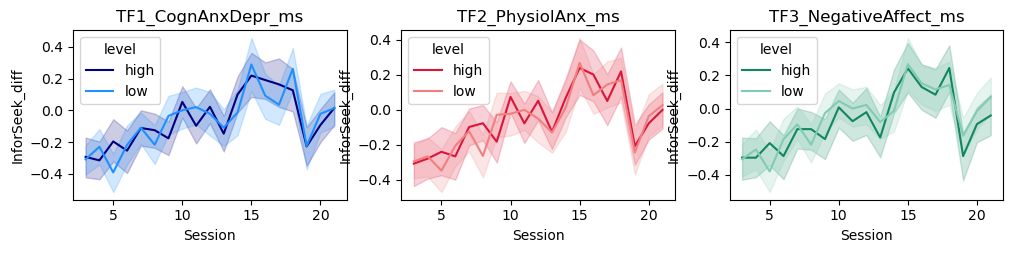

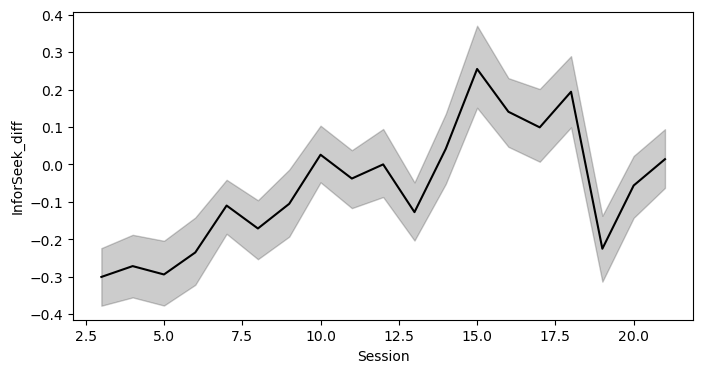

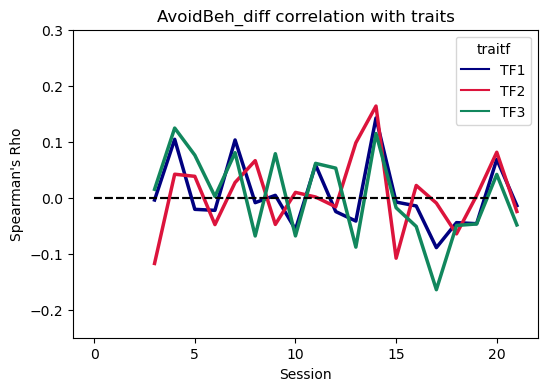

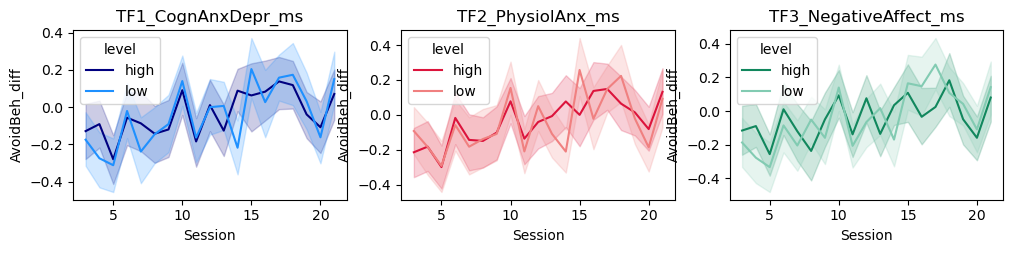

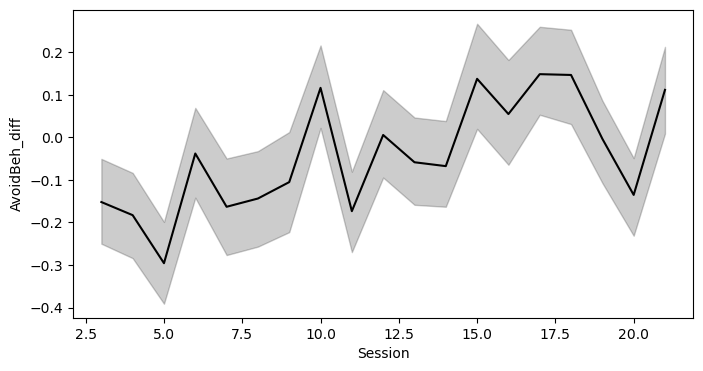

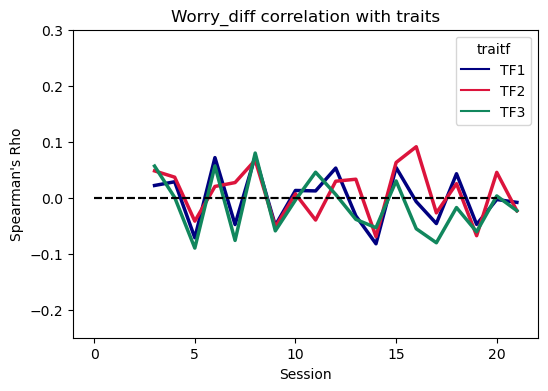

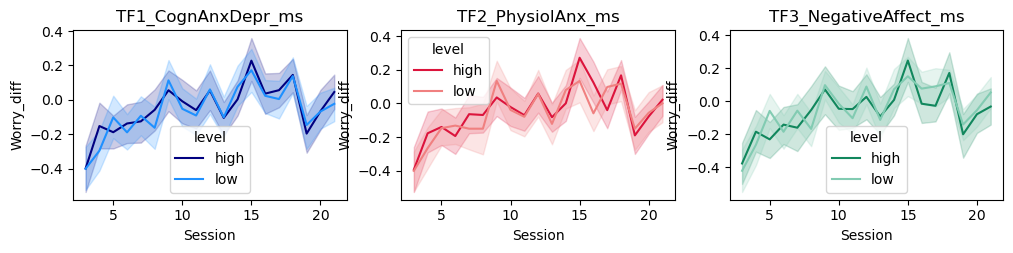

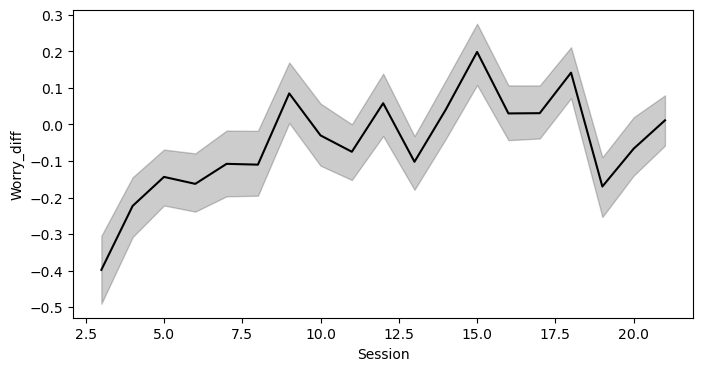

In [13]:
cordf
for v in cordf["index"].unique():
    print(v)
    td = cordf.loc[cordf["index"].isin([v]),:]
    td = td.melt(id_vars="Session", value_vars=tfs, var_name="traitf", value_name="corr" )

    f, ax = plt.subplots(1,1,figsize=(6,4))
    ax=sns.lineplot(data=td, x="Session", y="corr", hue="traitf", ax=ax, linewidth=2.5, palette=[colist[x][0] for x in range(3)])
    ax.set_title(v+ " correlation with traits")
    ax.set_ylabel("Spearman's Rho")

    ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])

    f, ax = plt.subplots(1,len(tfs),figsize=(12,2.2))
    f.subplots_adjust(hspace=0.65)
    for t_idx, t in enumerate([x+"_ms" for x in trait_factor_names]): 
        tdf = tdata.loc[tdata["traitf"].isin([t]),:]
        axx=sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[t_idx], palette=colist[t_idx])
        axx.set_title(t)

    plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  

    
    f,ax = plt.subplots(1,1, figsize=(8,4))
    ax = sns.lineplot(data=df, x="Session", y=v, ax=ax, legend=True, color= "black")

### Correlation of perception of dnager and deaths/cases

In [10]:
df["date"] = pd.to_datetime( df["submitdate"]).dt.strftime("%B '%y")
months = df.groupby(by="session")["date"].apply(lambda x: np.array(x.reset_index().iloc[0,1])).reset_index()
months["sessiontrue"] = months["session"] + 1
months["sessmonth_str"] = "S" + months["sessiontrue"].astype(str) + " (" + months["date"].astype(str) + ")"
pd.merge(df, months.loc[:,["sessmonth_str", "session"]], on='session')

PROLIFICID      PROLIFICID.1 GROUP  session  index  \
0     01S0stEpc3rU6YxK  01S0stEpc3rU6YxK    UK        1    217   
1     05c9AaLx1V20UAcO  05c9AaLx1V20UAcO    BE        1     82   
2     07GDvN1Nh0oHcEBM  07GDvN1Nh0oHcEBM    UK        1      4   
3     0OjnLzK5ABd2wO54  0OjnLzK5ABd2wO54    BE        1     11   
4     0Pe1blVigsBRLvBj  0Pe1blVigsBRLvBj    UK        1     47   
...                ...               ...   ...      ...    ...   
5820  zNbLeZqHa6wNHRLR  zNbLeZqHa6wNHRLR    UK       20   4937   
5821  zYWr4nlB9BwdVWFB  zYWr4nlB9BwdVWFB    UK       20   4929   
5822  zZGJnUM65XIz0F0X  zZGJnUM65XIz0F0X    UK       20   4927   
5823  zlOEoLWEAwlLTGbE  zlOEoLWEAwlLTGbE    UK       20   5067   
5824  ztPVSoIVH3QKpGeQ  ztPVSoIVH3QKpGeQ    UK       20   4968   

               submitdate  lastpage  sr_age sr_gender sr_postcode  ...  \
0              2020-04-18      12.0    32.0         F      DY98SN  ...   
1     2020-04-30 00:00:00      12.0    20.0         F      111321  ...   
2              2020-04-16      12.0    20.0         M      DD21NP  ...   
3     2020-04-22 00:00:00      12.0    24.0         F       14612  ...   
4              2020-04-17      12.0    23.0         M        RG21  ...   
...                   ...       ...     ...       ...         ...  ...   
5820           2020-12-14      12.0    33.0         F         SN6  ...   
5821           2020-12-14      12.0    19.0         F      CM16BW  ...   
5822           2020-12-14      12.0    29.0         F     GU513QH  ...   
5823           2020-12-15      12.0    23.0         F     IP117AB  ...   
5824           2020-12-14      12.0    37.0         M      CW55UG  ...   

      TF1_CognAnxDepr_ms  TF1_CognAnxDepr_ts  TF3_NegativeAffect_ms  \
0                   high                 mid                    low   
1                   high                 mid                    low   
2                    low                 low                    low   
3                    low                 low                    low   
4                   high                 mid                   high   
...                  ...                 ...                    ...   
5820                 low                 low                    low   
5821                high                 mid                   high   
5822                high                 mid                    low   
5823                high                high                   high   
5824                 low                 low                    low   

      TF3_NegativeAffect_ts  TF2_PhysiolAnx_ms  TF2_PhysiolAnx_ts     Cases  \
0                       mid                low                mid -0.372347   
1                       low               high               high -0.435430   
2                       low                low                low  0.698593   
3                       low               high               high -0.315917   
4                       mid               high                mid -0.075067   
...                     ...                ...                ...       ...   
5820                    low                low                low  0.992858   
5821                   high               high               high  1.530103   
5822                    mid                low                mid  0.974433   
5823                   high               high               high  1.527538   
5824                    low               high                mid  0.629123   

        Deaths  Session     sessmonth_str_y  
0     2.467453        2      S2 (April '20)  
1     0.534880        2      S2 (April '20)  
2     2.461171        2      S2 (April '20)  
3     0.705386        2      S2 (April '20)  
4     3.008552        2      S2 (April '20)  
...        ...      ...                 ...  
5820  0.238838       21  S21 (December '20)  
5821  0.469313       21  S21 (December '20)  
5822  0.215547       21  S21 (December '20)  
5823  0.804453       21  S21 (December '20)  
5824  0.836299       2

### Plot also marginalized posteriors 

In [11]:
df2 = pd.read_csv(os.path.join(root_dir, "output", "working_data", "full_dataset_with_predictions_basicmodel.csv"))
df2=df2.rename(columns=mapdict)
# Create column with appropriate dates
df2["Session"] = df2["session"] + 1
vars2 = [v+"_pred" for v in ["CurrThreat","ProbEst","InforSeek","AvoidBeh"]]

data = df2.groupby(by=[x+"_ms" for x in trait_factor_names] + ["PROLIFICID", "Session"])[["PROLIFICID"]+vars2].mean().reset_index()
tdata2 = data.melt(id_vars=vars2+["Session"], value_vars=[x+"_ms" for x in trait_factor_names], var_name="traitf", value_name="level" )

In [12]:
cordf = pd.DataFrame()
for s in df2["Session"].unique():
    

    data = df2.loc[df2["Session"]==s,vars2+tfs] # df.groupby(by="PROLIFICID")[["PROLIFICID", "state_severity"]+vars].mean()

    # calculate correlation matrix
    corr = data.corr(corr_type)
    #print(corr)
    corr2 = corr.loc[tfs, ~corr.index.isin(tfs)].T.reset_index()
    corr2["Session"] = s
    cordf = pd.concat([cordf, corr2])

CurrThreat_pred
ProbEst_pred
InforSeek_pred
AvoidBeh_pred


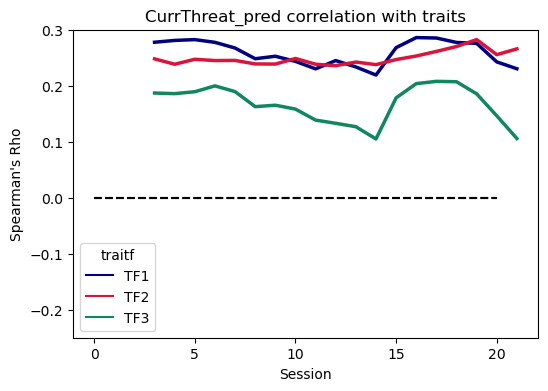

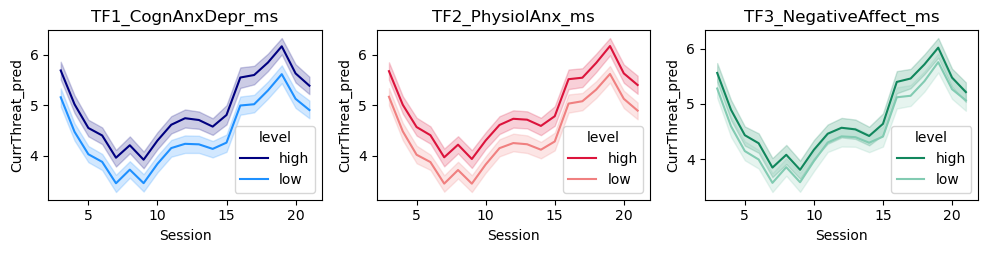

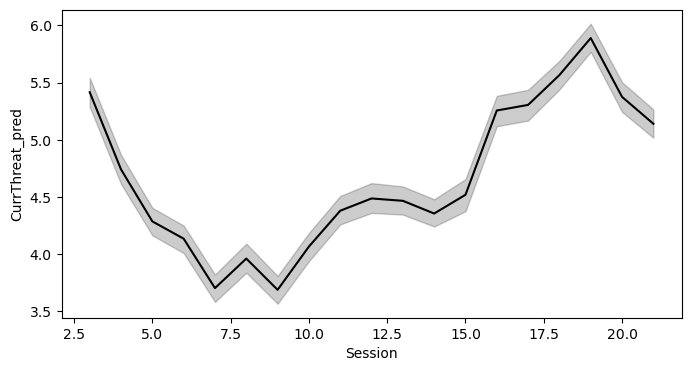

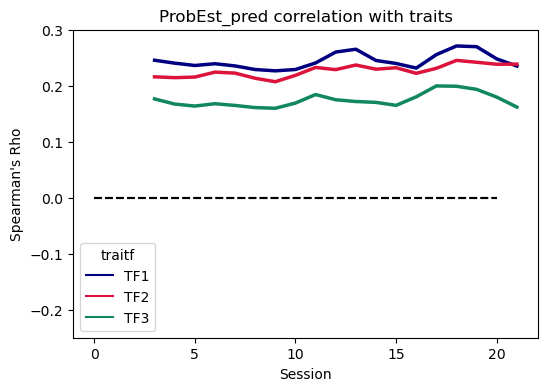

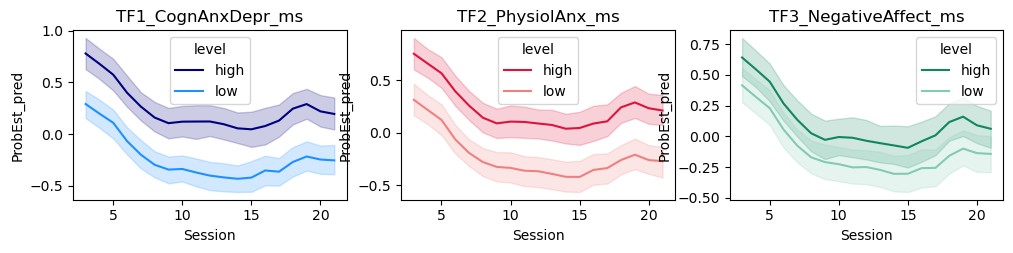

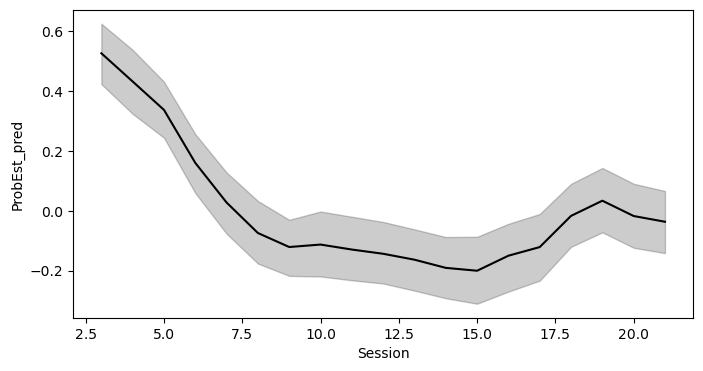

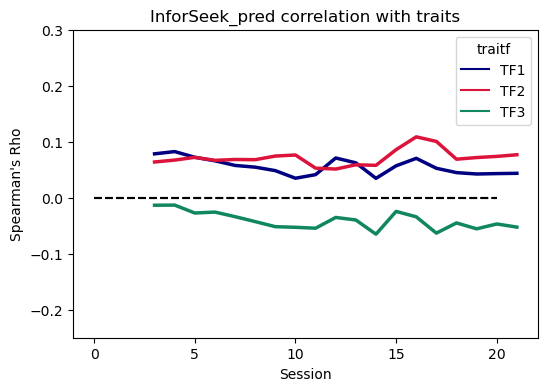

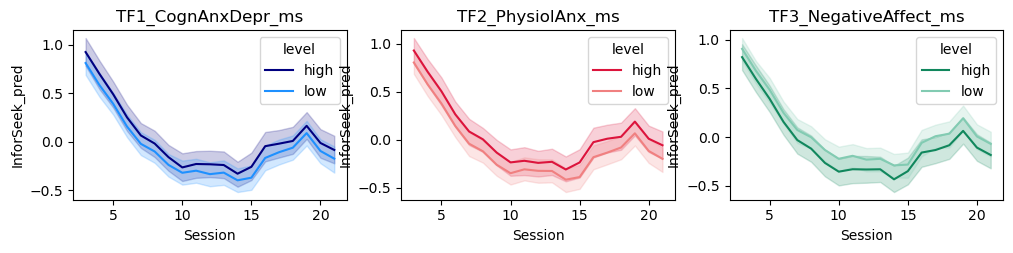

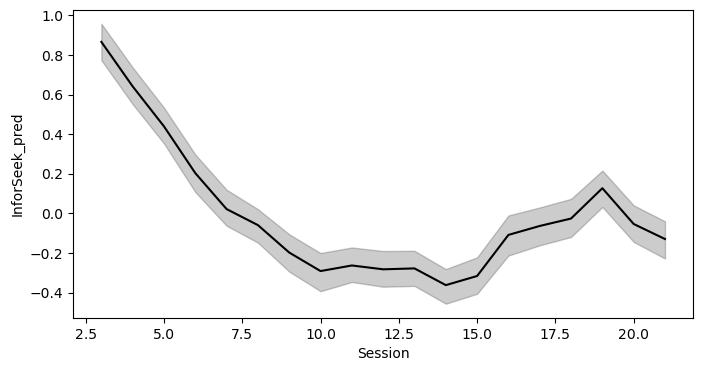

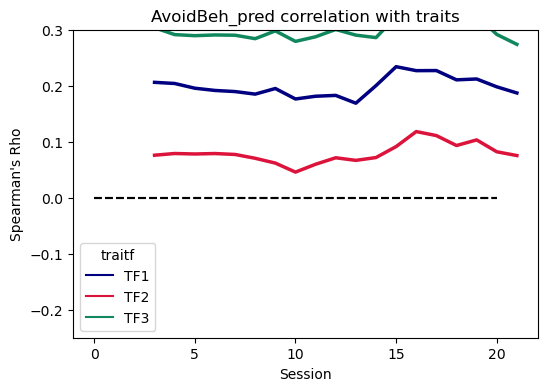

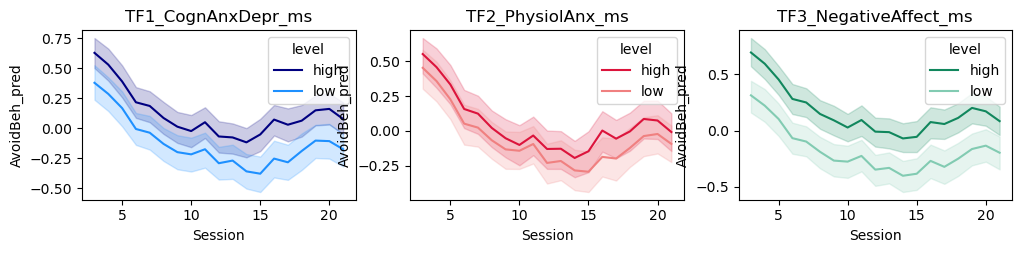

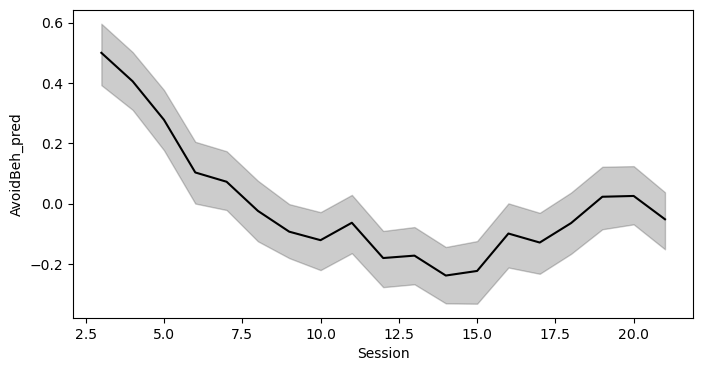

In [13]:
cordf
for v in cordf["index"].unique():
    print(v)
    td = cordf.loc[cordf["index"].isin([v]),:]
    td = td.melt(id_vars="Session", value_vars=tfs, var_name="traitf", value_name="corr" )

    f, ax = plt.subplots(1,1,figsize=(6,4))
    ax=sns.lineplot(data=td, x="Session", y="corr", hue="traitf", ax=ax, linewidth=2.5, palette=[colist[x][0] for x in range(3)])
    ax.set_title(v+ " correlation with traits")
    ax.set_ylabel("Spearman's Rho")

    ax.set_ylim([-0.25, 0.3])
    ax.hlines( [0, 0], 0, 20,linestyles='dashed', colors=['black'])

    f, ax = plt.subplots(1,len(tfs),figsize=(12,2.2))
    f.subplots_adjust(hspace=0.65)
    for t_idx, t in enumerate([x+"_ms" for x in trait_factor_names]): 
        tdf = tdata2.loc[tdata2["traitf"].isin([t]),:]
        axx=sns.lineplot(data=tdf, x="Session", y=v, hue="level", ax=ax[t_idx], palette=colist[t_idx])
        axx.set_title(t)

    #plt.savefig(os.path.join(root_dir, 'covid-fear', 'scripts', 'submissions_and_outputs',  'PUG_2024', v+'.pdf'), dpi=300, quality=80, optimize=True, progressive=True)  

    
    f,ax = plt.subplots(1,1, figsize=(8,4))
    ax = sns.lineplot(data=df2, x="Session", y=v, ax=ax, legend=True, color= "black")

## deaths with date labels